In [1]:
import numpy as np
import torch
import json
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from collections import defaultdict

from GAIL.models.nets import Expert
from GAIL.models.gail import GAIL

from utilities import *
from utilitiesDL import *

# torch.multiprocessing.set_start_method('spawn')

In [2]:
LSTMModelDir = './savedModels/selected/'

inputJsonFileName = 'test'

LSTMModelDir = './savedModels/selected/'
inputJsonFile = open("./inputJson/GAIL/" + inputJsonFileName + ".json", "r")
inputJson = json.load(inputJsonFile)
LSTMModelName = inputJson['LSTMModelName']
noiseAmpRatio = inputJson['noiseAmpRatio']
trDataRatio = inputJson['trDataRatio']
trExpDataRatio = inputJson['trExpDataRatio']
nHiddenGAIL = inputJson['nHiddenGAIL']
inputLenTime = inputJson['inputLenTime']
outputLenTime = inputJson['outputLenTime']
GAILTrainConfig = inputJson['trainConfig']

cudaID = 7
padLen = 9

torch.set_num_threads(1)

if cudaID >= 0:
    device = torch.device("cuda:"+str(cudaID))
    cudaAvbl = True
else:
    device = torch.device("cpu")
    cudaAvbl = False

dataType = LSTMModelName.split('_')[0]
if dataType == 'survey':
    fs = 1000 # 1 kHz
    nSubC = 30
    nRX = 3
    
    winLen = 1000
    thres = 60
    slideLen = 400
    activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']

    targetSingleAct = False
    testAct = 'run'

LSTMType = LSTMModelName.split('_')[1]
bidirectional = (LSTMType == 'BLSTM')
nHidden = int(LSTMModelName.split('_')[3])
threshold = int(LSTMModelName.split('_')[5])
nLayer = int(LSTMModelName.split('_')[7])

saveFileName = LSTMModelName + '_' + inputJsonFileName

# Load the LSTM model
HARNet = LSTMNet(nClasses=len(activities), input_size=nSubC*nRX, bidirectional=bidirectional,\
                hidden_size=nHidden, num_layers=1, seq_length=winLen//2, device=device)
HARNet.load_state_dict(torch.load(LSTMModelDir + LSTMModelName + '.cpkt', map_location='cuda:1'))
# HARNet.to(device)

# Load dataset labelled with FGM attack
FGMdatasetDir = '/project/iarpa/wifiHAR/HAR_' + dataType + '/window_FGM_pad_' + str(padLen) + '/'
dataDict = {file:[] for file in activities}
# tsDataDict = {file:[] for file in activities}

trExpDataset = list()
trAgentDataset = list()
# trDataset = list()
tsDataset = list()
correct = 0.0
nData = 0.0
# activities = ['walk']
for actInd, activity in enumerate(activities):
    dataDict[activity] = defaultdict(list)

    if not targetSingleAct or activity in testAct:
        dataInputActFileName = FGMdatasetDir + 'input_' + LSTMModelName + '_' + activity + '.npy'

        dataAct = np.load(dataInputActFileName)
        dataDict[activity]['obs'] =\
            torch.reshape(torch.squeeze(torch.tensor(dataAct).to(device)), (-1, (winLen//2+padLen), nSubC*nRX))
    
        dataNoiseActFileName = FGMdatasetDir + 'noise_' + LSTMModelName + '_' + activity + '.npy'
        dataNoise = np.load(dataNoiseActFileName)
        dataDict[activity]['FGM'] = noiseAmpRatio *\
            torch.reshape(torch.squeeze(torch.tensor(dataNoise).to(device)), (-1, (winLen//2), nSubC*nRX))
        
        dataDict[activity]['label'] =\
            (actInd) * torch.ones_like(torch.empty(dataDict[activity]['obs'].shape[0], device=device), dtype=int) 
    
        trObsBatchwoPad = dataDict[activity]['obs'][:, padLen:, :]
        # print('obs:', trObsBatchwoPad.shape, 'FGM:',\
        #     dataDict[activity]['FGM'].shape, 'label:', dataDict[activity]['label'].shape)

        pred_l,label_l = getPredsGAIL(trObsBatchwoPad, dataDict[activity]['FGM'], dataDict[activity]['label'],\
                                    HARNet, noiseAmpRatio)
        for pred, label in zip(pred_l, label_l):
            nData += 1
            correct += (pred == label)

        
        datasetAct = FGMDataset(dataDict[activity], device)
        trExpDataset.append(torch.utils.data.Subset(datasetAct,\
                                                    range(int(trDataRatio*trExpDataRatio*len(datasetAct)))))
        trAgentDataset.append(torch.utils.data.Subset(datasetAct,\
                                                    range(int(trDataRatio*trExpDataRatio*len(datasetAct)),\
                                                            int(trDataRatio*len(datasetAct)))))
        tsDataset.append(torch.utils.data.Subset(datasetAct,\
                                                range(int(trDataRatio*len(datasetAct)), len(datasetAct))))

        print('activity:', activity, 'trExpDataset:', len(trExpDataset[-1]),\
            'trAgentDataset:', len(trAgentDataset[-1]), 'tsDataset:', len(tsDataset[-1]))

trExpLoader = DataLoader(torch.utils.data.ConcatDataset(trExpDataset),\
                      batch_size=10, shuffle=True, generator=torch.Generator(device=device))
trAgentLoader = DataLoader(torch.utils.data.ConcatDataset(trAgentDataset),\
                      batch_size=10, shuffle=True, generator=torch.Generator(device=device))
tsLoader = DataLoader(torch.utils.data.ConcatDataset(tsDataset),\
                      batch_size=10, shuffle=True, generator=torch.Generator(device=device))

# print('trExpLoader:', len(trExpLoader), 'trAgentLoader', len(trAgentLoader), 'tsLoader:', len(tsLoader))

activity: fall trExpDataset: 93 trAgentDataset: 40 tsDataset: 311
activity: pickup trExpDataset: 102 trAgentDataset: 44 tsDataset: 343
activity: run trExpDataset: 253 trAgentDataset: 109 tsDataset: 847
activity: sitdown trExpDataset: 86 trAgentDataset: 38 tsDataset: 290
activity: standup trExpDataset: 63 trAgentDataset: 28 tsDataset: 213
activity: walk trExpDataset: 308 trAgentDataset: 132 tsDataset: 1027


In [3]:
import numpy as np
import torch

from torch.nn import Module

from GAIL.models.nets import PolicyNetwork, ValueNetwork, Discriminator
from GAIL.utils.funcs import get_flat_grads, get_flat_params, set_params, \
    conjugate_gradient, rescale_and_linesearch

if torch.cuda.is_available():
    from torch.cuda import FloatTensor
    torch.set_default_tensor_type(torch.cuda.FloatTensor)
else:
    from torch import FloatTensor


class GAIL(Module):
    def __init__(
        self,
        state_dim,
        action_dim,
        nHidden,
        padLen,
        inputLenTime,
        outputLenTime,
        discrete,
        device,
        train_config=None
    ) -> None:
        super().__init__()

        self.state_dim = state_dim
        self.action_dim = action_dim
        self.nHidden = nHidden
        self.padLen = padLen
        self.inputLenTime = inputLenTime
        self.outputLenTime = outputLenTime
        self.discrete = discrete
        self.device = device
        self.train_config = train_config

        self.pi = PolicyNetwork(self.state_dim * self.inputLenTime,\
                                self.action_dim * self.outputLenTime,\
                                self.nHidden, self.discrete, self.device)
        self.v = ValueNetwork(self.state_dim * self.inputLenTime,\
                              self.nHidden, self.device)
        self.d = Discriminator(self.state_dim * self.inputLenTime,\
                            self.action_dim * self.outputLenTime,\
                            self.nHidden, self.discrete, self.device)

    def get_networks(self):
        return [self.pi, self.v]

    def act(self, state):
        self.pi.eval()
        state = FloatTensor(state)
        action = self.pi(state).sample()
        
        return action
    
    def eval(self, trAgentLoader, pi):
        self.pi.load_state_dict(pi.state_dict())
        self.pi.eval()
        
        nDataTrAgent = 0
        for trAgentBatch in trAgentLoader:
            nDataTrAgent += trAgentBatch['obs'].shape[0]

        noiseAmpRatioList = [1e-5, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5]
        correct = [0. for _ in noiseAmpRatioList]
        lineBreakCount = 0
        for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
            for trAgentBatch in trAgentLoader:
                seqLength = (trAgentBatch['obs'].shape[1] - self.padLen) // self.outputLenTime

                obsBatch = torch.Tensor().to(device)
                for inputLenIndex in range(self.inputLenTime):
                    obsBatch = torch.cat((obsBatch,\
                        trAgentBatch['obs'][:, (padLen-self.inputLenTime+inputLenIndex+1):\
                                            (padLen-self.inputLenTime+inputLenIndex+1+\
                                            (seqLength*self.outputLenTime)):self.outputLenTime,:]), dim=2)
                obsBatchFlatten = obsBatch.reshape(-1, obsBatch.shape[2])

                actBatchFlatten = self.act(obsBatchFlatten)
                actBatch = actBatchFlatten.reshape(seqLength, -1, self.action_dim*self.outputLenTime).transpose(0,1)
                actLastBatch = torch.zeros((actBatch.shape[0], (seqLength*self.outputLenTime), self.action_dim), device=device)
                for outputLenIndex in range(self.outputLenTime):
                    actLastBatch[:, outputLenIndex::self.outputLenTime, :] =\
                        actBatch[:, :, outputLenIndex*self.action_dim:(outputLenIndex+1)*self.action_dim]

                obsLastBatch = obsLastBatch = trAgentBatch['obs'][:, padLen:, :]
                pred_l,label_l = getPredsGAIL(obsLastBatch,\
                                                actLastBatch, trAgentBatch['label'], HARNet, noiseAmpRatio)
                for pred, label in zip(pred_l, label_l):
                    correct[noiseAmpIndex] += (pred == label)

            print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct[noiseAmpIndex]/nDataTrAgent), end=' ')
            lineBreakCount += 1
            if lineBreakCount == 5:
                print('')
                lineBreakCount = 0
        if lineBreakCount != 0:
            print('')


    def train(self, HARNet, trExpLoader, trAgentLoader, tsLoader, render=False):
        num_iters = self.train_config["num_iters"]
        lambda_ = self.train_config["lambda"]
        gae_gamma = self.train_config["gae_gamma"]
        gae_lambda = self.train_config["gae_lambda"]
        eps = self.train_config["epsilon"]
        max_kl = self.train_config["max_kl"]
        cg_damping = self.train_config["cg_damping"]
        opt_d_LR = self.train_config["opt_d_LR"]
        normalize_advantage = self.train_config["normalize_advantage"]

        opt_d = torch.optim.Adam(self.d.parameters(), lr=opt_d_LR)

        noiseAmpRatioList = [1e-4, 1e-3, 1e-2, 0.1, 0.2]
        # noiseAmpRatioList = [10]
        print('----White-box attack performance (Expert)----')
        print('[ampRatio, Acc.]:', end=' ')
        nDataTrExp = 0
        for trExpBatch in trExpLoader:
            nDataTrExp += trExpBatch['obs'].shape[0]
        nDataTrAgent = 0
        for trAgentBatch in trAgentLoader:
            nDataTrAgent += trAgentBatch['obs'].shape[0]
        nDataTs = 0
        for tsBatch in tsLoader:
            nDataTs += tsBatch['obs'].shape[0]

        lineBreakCount = 0
        for noiseAmpRatio in noiseAmpRatioList:
            correct = 0.
            for trAgentBatch in trAgentLoader:
                seqLength = (trAgentBatch['obs'].shape[1] - self.padLen) // self.outputLenTime
                trObsBatchwoPad = trAgentBatch['obs'][:, padLen:, :]
                pred_l,label_l = getPredsGAIL(trObsBatchwoPad, trAgentBatch['FGM'], trAgentBatch['label'],\
                                              HARNet, noiseAmpRatio)
                for pred, label in zip(pred_l, label_l):
                    correct += (pred == label)
            print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTrAgent), end=' ')
            lineBreakCount += 1
            if lineBreakCount == 5:
                print('')
                lineBreakCount = 0
        if lineBreakCount != 0:
            print('')

        print('----Random noise attack performance----')
        print('[ampRatio, Acc.]:', end=' ')
        for noiseAmpRatio in noiseAmpRatioList:
            correct = 0.
            lineBreakCount = 0
            for trAgentBatch in trAgentLoader:
                trObsBatchwoPad = trAgentBatch['obs'][:, padLen:, :]
                noiseBatch = torch.randn(trObsBatchwoPad.shape).to(device)
                pred_l,label_l = getPredsGAIL(trObsBatchwoPad, noiseBatch, trAgentBatch['label'],\
                                              HARNet, noiseAmpRatio)
                for pred, label in zip(pred_l, label_l):
                    correct += (pred == label)
                # accuracyList.append(correct/nData)
            print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTrAgent), end=' ')
            lineBreakCount += 1
            if lineBreakCount == 5:
                print('')
                lineBreakCount = 0
        if lineBreakCount != 0:
            print('')

        print('nDataTrExp:', nDataTrExp, 'nDataTrAgent:', nDataTrAgent, 'nDataTs:', int(nDataTs))
        bestAcc = 1.0
        accHistory = np.zeros((num_iters, len(noiseAmpRatioList)))
        for iIter in range(num_iters):
            if lineBreakCount != 0 and iIter!= 0:
                print('')
            print('Iter {}'.format(iIter), end=' ')
            
            obs = []
            acts = []
            rets = []
            advs = []
            gms = []

            correct = [0. for _ in noiseAmpRatioList]
            for _, trAgentBatch in enumerate(trAgentLoader):
                # obsAmp = LA.norm(trAgentBatch['obs'].view(trAgentBatch['obs'].shape[0], -1), dim=1)
                obsBatch = torch.Tensor().to(device)
                for inputLenIndex in range(self.inputLenTime):
                    obsBatch = torch.cat((obsBatch,\
                        trAgentBatch['obs'][:, (padLen-self.inputLenTime+inputLenIndex+1):\
                                            (padLen-self.inputLenTime+inputLenIndex+1+\
                                            (seqLength*self.outputLenTime)):self.outputLenTime,:]), dim=2)
                obsBatchFlatten = obsBatch.reshape(-1, obsBatch.shape[2])

                actBatchFlatten = self.act(obsBatchFlatten)
                actBatch = actBatchFlatten.reshape(seqLength, -1, self.action_dim*self.outputLenTime).transpose(0,1)
                # print('actBatch agent:', actBatch.shape)

                obsLastBatch = trAgentBatch['obs'][:, padLen:, :]
                actLastBatch = torch.zeros((actBatch.shape[0], (seqLength*self.outputLenTime), self.action_dim), device=device)
                for outputLenIndex in range(self.outputLenTime):
                    actLastBatch[:, outputLenIndex::self.outputLenTime, :] =\
                        actBatch[:, :, outputLenIndex*self.action_dim:(outputLenIndex+1)*self.action_dim]

                for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
                    pred_l,label_l = getPredsGAIL(obsLastBatch,\
                                                  actLastBatch, trAgentBatch['label'], HARNet, noiseAmpRatio)
                    for pred, label in zip(pred_l, label_l):
                        correct[noiseAmpIndex] += (pred == label)
                    
                obs.append(obsBatchFlatten)
                acts.append(actBatchFlatten)

                retsBatch = torch.Tensor().to(device)
                advsBatch = torch.Tensor().to(device)
                gmsBatch = torch.Tensor().to(device)
                for trajIndex, trAgentData in enumerate(obsBatch):
                    ep_obs = trAgentData
                    ep_acts = torch.squeeze(actBatch[trajIndex, :, :])
                    ep_gms = torch.pow(gae_gamma, torch.arange(seqLength)).to(device)
                    ep_lmbs = torch.pow(gae_lambda, torch.arange(seqLength)).to(device)

                    ep_costs = (-1) * torch.log(self.d(ep_obs, ep_acts)).squeeze().detach()
                    ep_disc_costs = ep_gms * ep_costs
                    ep_disc_rets = torch.flip(torch.flip(\
                        ep_disc_costs.to(device), dims=[0]).cumsum(dim=0), dims=[0])
                    # ep_disc_rets = FloatTensor([sum(ep_disc_costs[i:]) for i in range(seqLength)]).to(device)
                    ep_rets = ep_disc_rets / ep_gms
                    retsBatch = torch.cat((retsBatch, ep_rets), dim=0)

                    self.v.eval()
                    curr_vals = self.v(ep_obs).detach()
                    next_vals = torch.cat(
                        (self.v(ep_obs)[1:], FloatTensor([[0.]]).to(device))).detach()
                    ep_deltas = ep_costs.unsqueeze(-1) + gae_gamma * next_vals - curr_vals
                    ep_advs = FloatTensor([
                        ((ep_gms * ep_lmbs)[:seqLength - j].unsqueeze(-1) * ep_deltas[j:]).sum()
                        for j in range(seqLength)]).to(device)

                    advsBatch = torch.cat((advsBatch, ep_advs))
                    gmsBatch = torch.cat((gmsBatch, ep_gms))
                
                rets.append(retsBatch)
                advs.append(advsBatch)
                gms.append(gmsBatch)
            
            # print('rets:', len(rets), 'advs:', len(advs), 'gms:', len(gms))
            if normalize_advantage:
                advsFlatten = torch.cat(advs)
                advsFlatten = (advsFlatten - advsFlatten.mean()) / (advsFlatten.std() + 1e-8)
                advs = torch.split(advsFlatten, [len(advsBatch) for advsBatch in advs])
                
            self.d.train()
            expScores = torch.Tensor().to(device)
            for trExpBatch in trExpLoader:
                expObsBatch = torch.Tensor().to(device)
                for inputLenIndex in range(self.inputLenTime):
                    expObsBatch = torch.cat((expObsBatch,\
                        trExpBatch['obs'][:, (padLen-self.inputLenTime+inputLenIndex+1):\
                                            (padLen-self.inputLenTime+inputLenIndex+1+\
                                            (seqLength*self.outputLenTime)):self.outputLenTime,:]), dim=2)
                expObsBatch = expObsBatch.reshape(-1, expObsBatch.shape[2])

                expActBatch = torch.zeros((trExpBatch['FGM'].shape[0],\
                                           seqLength, self.action_dim*self.outputLenTime), device=device)
                for outputLenIndex in range(self.outputLenTime):
                    expActBatch[:, :, outputLenIndex*self.action_dim:(outputLenIndex+1)*self.action_dim] =\
                        trExpBatch['FGM'][:, outputLenIndex::self.outputLenTime, :]
                expActBatch = expActBatch.reshape(-1, expActBatch.shape[2])

                # expScores = self.d.get_logits(expObsBatch, expActBatch)
                expScores = torch.cat((expScores, self.d.get_logits(expObsBatch, expActBatch)), dim=0)
            
            agentScores = torch.Tensor().to(device)
            for agentObsBatch, agentActsBatch in zip(obs, acts):
                agentScores = torch.cat((agentScores, self.d.get_logits(agentObsBatch, agentActsBatch)), dim=0)

            opt_d.zero_grad()
            lossExp = torch.nn.functional.binary_cross_entropy_with_logits(\
                expScores, torch.zeros_like(expScores))
            lossAgent = torch.nn.functional.binary_cross_entropy_with_logits(\
                agentScores, torch.ones_like(agentScores))
            loss = lossExp + lossAgent
            loss.backward()
            opt_d.step()

            print('scores: {0:.3f}, {1:.3f}'.format\
                  (torch.mean(expScores).item(), torch.mean(agentScores).item()), end=' ')

            del expScores
            del agentScores

            self.v.train()
            for obsBatch, actsBatch, retsBatch in zip(obs, acts, rets):
                old_params = get_flat_params(self.v).detach()
                old_vBatch = self.v(obsBatch).detach()
            
                def constraint():
                    return ((old_vBatch - self.v(obsBatch)) ** 2).mean()
            
                grad_diff = get_flat_grads(constraint(), self.v)

                def Hv(v):
                    hessian = get_flat_grads(torch.dot(grad_diff, v), self.v).detach()
                    return hessian

                g = get_flat_grads(\
                    (-1*(self.v(obsBatch).squeeze() - retsBatch) ** 2).mean(), self.v).detach()
                s = conjugate_gradient(Hv, g).detach()
                Hs = Hv(s).detach()
                alpha = torch.sqrt(2 * eps / (torch.dot(s, Hs) + 1e-8)).detach()
                new_params = old_params + alpha * s
                # print('v:', old_params.norm().item(), alpha.item(), s.norm().item())
                set_params(self.v, new_params)
                # print('v:', self.v.net[0].weight[1, :2].squeeze())

            # print('iter final v:', self.v.net[0].weight[1, :5].squeeze().detach().cpu().numpy())
            
            self.pi.train()
            for obsBatch, actsBatch, advsBatch, gmsBatch in zip(obs, acts, advs, gms):
                # print(obsBatch.shape, actsBatch.shape, advsBatch.shape, gmsBatch.shape)
                old_params = get_flat_params(self.pi).detach()
                old_distb = self.pi(obsBatch)

                def L():
                    distb = self.pi(obsBatch)
                    return (advsBatch * torch.exp(distb.log_prob(actsBatch)\
                                    - old_distb.log_prob(actsBatch).detach())).mean()
                    # return torch.distributions.kl.kl_divergence(distb, old_distb).mean()

                def kld():
                    distb = self.pi(obsBatch)
                    old_mean = old_distb.mean.detach()
                    old_cov = old_distb.covariance_matrix.sum(-1).detach()
                    mean = distb.mean
                    cov = distb.covariance_matrix.sum(-1)
                    return (0.5) * ((old_cov / cov).sum(-1)\
                            + (((old_mean - mean) ** 2) / cov).sum(-1)
                            - (self.action_dim * self.outputLenTime)
                            + torch.log(cov).sum(-1)
                            - torch.log(old_cov).sum(-1)).mean()

                grad_kld_old_param = get_flat_grads(kld(), self.pi)

                def Hv(v):
                    hessian = get_flat_grads(torch.dot(grad_kld_old_param, v), self.pi).detach()
                    return hessian + cg_damping * v
                
                g = get_flat_grads(L(), self.pi).detach()
                s = conjugate_gradient(Hv, g).detach()
                Hs = Hv(s).detach()
                new_params = rescale_and_linesearch(g, s, Hs, max_kl, L, kld, old_params, self.pi)

                disc_causal_entropy = ((-1) * gmsBatch * self.pi(obsBatch).log_prob(actsBatch)).mean()
                grad_disc_causal_entropy = get_flat_grads(disc_causal_entropy, self.pi)
                new_params += lambda_ * grad_disc_causal_entropy

                set_params(self.pi, new_params)
            
            # print('iter final pi:', self.pi.net[0].weight[1, :5].squeeze().detach().cpu().numpy())

            print('[ampRatio, Acc.]:', end=' ')
            lineBreakCount = 0
            ampSaveCriterion = 0.1
            for noiseAmpIndex, noiseAmpRatio in enumerate(noiseAmpRatioList):
                print('[{0}, {1:.3f}]'.\
                        format(noiseAmpRatio, correct[noiseAmpIndex]/nDataTrAgent), end=' ')
                accHistory[iIter, noiseAmpIndex] = correct[noiseAmpIndex]/nDataTrAgent

                lineBreakCount += 1
                if lineBreakCount == 5:
                    print('')
                    lineBreakCount = 0

            with open('./savedModels/GAIL/logs/' + saveFileName + '_accHistory.npy', 'wb') as f:
                # print(iIter, end=' ')
                # print(accHistory[iIter, :])
                np.save(f, accHistory)

            compAmpRatio = np.where(np.array(noiseAmpRatioList) == ampSaveCriterion)[0][0]
            if correct[compAmpRatio]/nDataTrAgent < bestAcc:
                bestAcc = correct[compAmpRatio]/nDataTrAgent
                torch.save(self.pi.state_dict(), './savedModels/GAIL/' + saveFileName + '_pi.cpkt')
                torch.save(self.v.state_dict(), './savedModels/GAIL/' + saveFileName + '_v.cpkt')
                torch.save(self.d.state_dict(), './savedModels/GAIL/' + saveFileName + '_d.cpkt')
                print('model saved!')

In [ ]:
inputLenTime = 10
outputLenTime = 2
print(inputLenTime, outputLenTime)
model = GAIL(state_dim=nSubC*nRX,\
            action_dim=nSubC*nRX,\
            nHidden=nHiddenGAIL,\
            padLen=padLen,\
            inputLenTime=inputLenTime,\
            outputLenTime=outputLenTime,\
            discrete=False,\
            device=device,\
            train_config=GAILTrainConfig)
# print(trExpLoader.device)
model.train(HARNet, trExpLoader, trAgentLoader, tsLoader)

10 2
----White-box attack performance (Expert)----
[ampRatio, Acc.]: [0.0001, 1.000] [0.001, 1.000] [0.01, 0.538] [0.1, 0.136] [0.2, 0.106] 
----Random noise attack performance----
[ampRatio, Acc.]: [0.0001, 1.000] [0.001, 1.000] [0.01, 1.000] [0.1, 0.947] [0.2, 0.477] 
nDataTrExp: 308 nDataTrAgent: 132 nDataTs: 1027
Iter 0 scores: -0.224, -0.227 [ampRatio, Acc.]: [0.0001, 1.000] [0.001, 1.000] [0.01, 1.000] [0.1, 0.970] [0.2, 0.598] 
model saved!
Iter 1 scores: -0.161, -0.132 [ampRatio, Acc.]: [0.0001, 1.000] [0.001, 1.000] [0.01, 1.000] [0.1, 0.939] [0.2, 0.417] 
model saved!
Iter 2 scores: -0.104, -0.045 [ampRatio, Acc.]: [0.0001, 1.000] [0.001, 1.000] [0.01, 1.000] [0.1, 0.955] [0.2, 0.553] 
Iter 3 scores: -0.057, 0.033 [ampRatio, Acc.]: [0.0001, 1.000] [0.001, 1.000] [0.01, 1.000] [0.1, 0.985] [0.2, 0.667] 
Iter 4 scores: -0.020, 0.099 [ampRatio, Acc.]: [0.0001, 1.000] [0.001, 1.000] [0.01, 1.000] [0.1, 0.985] [0.2, 0.606] 
Iter 5 scores: 0.006, 0.152 [ampRatio, Acc.]: [0.0001, 1.

KeyboardInterrupt: 

In [7]:
# HARNet = LSTMNet(nClasses=len(activities), input_size=nSubC*nRX, bidirectional=bidirectional,\
#                  hidden_size=nHidden, num_layers=nLayer, seq_length=winLen//2, device=device)

inputLenTime = 5
outputLenTime = 1
nHiddenGAIL = 200
LRstr = '2e-6'
# testAct = 'fall'
pi = PolicyNetwork(nSubC*nRX*inputLenTime, nSubC*nRX*outputLenTime, nHiddenGAIL, False, device)
# v = ValueNetwork(nSubC*nRX, device)
# d = Discriminator(nSubC*nRX, nSubC*nRX, False, device)
print(targetSingleAct, testAct)

# GAILConfigName = 'GAILConfig01_LRe-3'
if targetSingleAct:
    GAILConfigName = 'GAILJson_' +str(nHiddenGAIL) + '_in_' + str(inputLenTime) + '_out_' + str(outputLenTime) + '_LR' + LRstr + '_' + testAct
else:
    GAILConfigName = 'GAILJson_TL_' + str(inputLenTime) + '_' + str(nHiddenGAIL) + '_LR' + LRstr

pi.load_state_dict(torch.load('./savedModels/GAIL/' + LSTMModelName + '_' + GAILConfigName + '_pi.cpkt', map_location='cuda:0'))
GAILEvalModel = GAIL(state_dim=nSubC*nRX, action_dim=nSubC*nRX, nHidden=nHiddenGAIL,\
            padLen=padLen, inputLenTime=inputLenTime, outputLenTime=outputLenTime, discrete=False,\
            device=device, train_config=GAILTrainConfig)

GAILEvalModel.eval(trAgentLoader, pi)

True run
[1e-05, 0.974] [0.0001, 0.974] [0.0005, 0.974] [0.001, 0.974] [0.002, 0.974] 
[0.005, 0.974] [0.01, 0.972] [0.02, 0.972] [0.05, 0.957] [0.075, 0.877] 
[0.1, 0.775] [0.2, 0.591] [0.5, 0.455] 


GAILJson_200_in_5_out_1_LR2e-6 (2000, 4)


(0.0, 1.0)

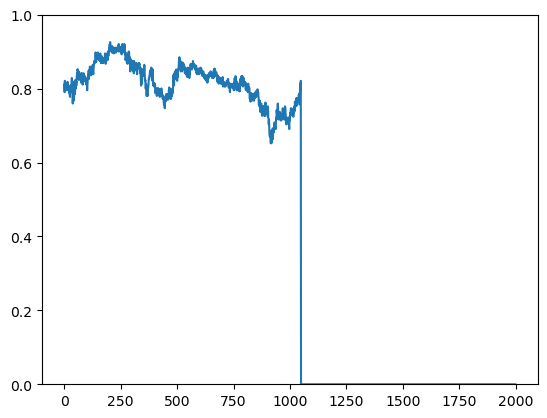

In [4]:
inputLenTime = 5
outputLenTime = 1
nHiddenGAIL = 200
LRstr = '2e-6'

# GAILConfigName = 'GAILJson_TL_' + str(inputLenTime) + '_' + str(nHiddenGAIL) + '_LR' + LRstr
# GAILConfigName = 'GAILJson_' +str(nHiddenGAIL) + '_in_' + str(inputLenTime) + '_out_' + str(outputLenTime) + '_LR' + LRstr
GAILConfigName = 'GAILJson_' +str(nHiddenGAIL) + '_in_' + str(inputLenTime) + '_out_' + str(outputLenTime) + '_LR' + LRstr + '_' + testAct

accHistory = np.load('./savedModels/GAIL/logs/' + LSTMModelName + '_' + GAILConfigName + '_accHistory.npy')
print(GAILConfigName, accHistory.shape)
# with open('./savedModels/GAIL/logs/' + LSTMModelName + '_test_accHistory.npy', 'rb') as f:
#     accHistory = np.load(f)
# accHistory = np.load('./savedModels/GAIL/logs/' + LSTMModelName + '_test_accHistory.npy')

# accHistory[:300, -1]

plt.plot(accHistory[:2000, 3])
plt.ylim([0, 1])

In [38]:
nDataTrAgent = 0
for trAgentBatch in trAgentLoader:
    nDataTrAgent += trAgentBatch['obs'].shape[0]
noiseAmpRatioList = [1e-5, 1e-4, 5e-4, 1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 7.5e-2, 0.1, 0.2, 0.5]

lineBreakCount = 0
for noiseAmpRatio in noiseAmpRatioList:
    correct = 0.
    
    for trAgentBatch in trAgentLoader:
        pred_l,label_l = getPredsGAIL(trAgentBatch['obs'], trAgentBatch['FGM'], trAgentBatch['label'],\
                                        HARNet, noiseAmpRatio)
        for pred, label in zip(pred_l, label_l):
            correct += (pred == label)
    print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTrAgent), end=' ')
    lineBreakCount += 1
    if lineBreakCount == 4:
        print('')
        lineBreakCount = 0

if lineBreakCount != 0:
    print('')
lineBreakCount = 0
for noiseAmpRatio in noiseAmpRatioList:
    correct = 0.
    for trAgentBatch in trAgentLoader:
        noiseBatch = torch.randn(trAgentBatch['obs'].shape).to(device)
        pred_l,label_l = getPredsGAIL(trAgentBatch['obs'], noiseBatch, trAgentBatch['label'],\
                                        HARNet, noiseAmpRatio)
        for pred, label in zip(pred_l, label_l):
            correct += (pred == label)
        # accuracyList.append(correct/nData)
    print('[{0}, {1:.3f}]'.format(noiseAmpRatio, correct/nDataTrAgent), end=' ')
    lineBreakCount += 1
    if lineBreakCount == 4:
        print('')
        lineBreakCount = 0



RuntimeError: shape '[10, 509, 90]' is invalid for input of size 450000

[Text(0, 0, 'Fall'),
 Text(0, 1, 'Lie down'),
 Text(0, 2, 'Run'),
 Text(0, 3, 'Sit down'),
 Text(0, 4, 'Stand up'),
 Text(0, 5, 'Walk')]

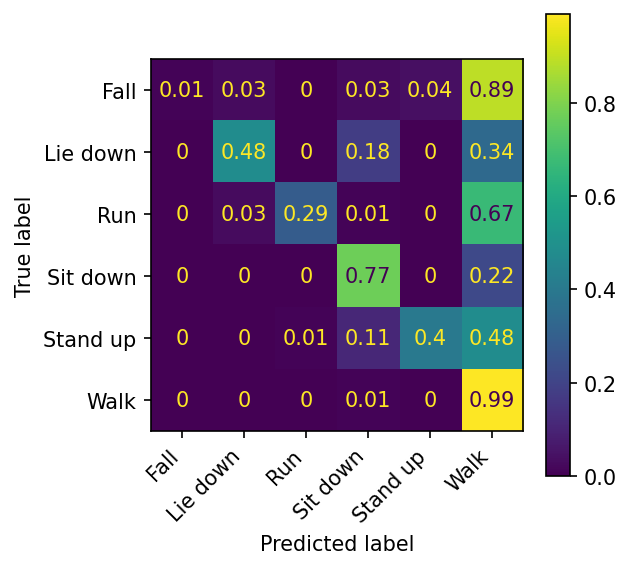

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

LRstr = '1e-3'
targetSingleAct = True
# testAct = 'walk'
if targetSingleAct:
    GAILConfigName = 'GAILJson_' +str(nHiddenGAIL) + '_in_' + str(inputLenTime) + '_out_' + str(outputLenTime) + '_LR' + LRstr + '_' + testAct
else:
    GAILConfigName = 'GAILJson_TL_' + str(inputLenTime) + '_' + str(nHiddenGAIL) + '_LR' + LRstr

noiseAmpRatio = 0.1
pred_l = []
label_l = []
nHiddenGAIL = 50
inputLenTime = 1

GAILEvalModel = GAIL(state_dim=nSubC*nRX, action_dim=nSubC*nRX, nHidden=nHiddenGAIL,\
            padLen=padLen, inputLenTime=inputLenTime, outputLenTime=outputLenTime, discrete=False,\
            device=device, train_config=GAILTrainConfig)

activities = ['fall', 'pickup', 'run', 'sitdown', 'standup', 'walk']
for actInd, activity in enumerate(activities):
    trAgentDataset = list()
    # GAILConfigName = 'GAILJson_' +str(nHiddenGAIL) + '_in_' + str(inputLenTime) + '_out_' + str(outputLenTime) + '_LR' + LRstr
    GAILConfigName = 'GAILJson_' +str(nHiddenGAIL) + '_in_' + str(inputLenTime) + '_out_' + str(outputLenTime) + '_LR' + LRstr + '_' + activity
    GAILConfigName = 'GAILConfig01_LRe-3'

    GAILEvalModel.pi.load_state_dict(torch.load('./savedModels/selected/' + LSTMModelName + '_' + GAILConfigName + '_pi.cpkt', map_location='cuda:0'))
    GAILEvalModel.pi.eval()

    dataDict[activity] = defaultdict(list)
    dataInputActFileName = FGMdatasetDir + 'input_' + LSTMModelName + '_' + activity + '.npy'
    dataAct = np.load(dataInputActFileName)
    dataDict[activity]['obs'] =\
        torch.reshape(torch.squeeze(torch.tensor(dataAct).to(device)), (-1, (winLen//2+padLen), nSubC*nRX))
    dataNoiseActFileName = FGMdatasetDir + 'noise_' + LSTMModelName + '_' + activity + '.npy'
    dataNoise = np.load(dataNoiseActFileName)
    dataDict[activity]['FGM'] = noiseAmpRatio *\
        torch.reshape(torch.squeeze(torch.tensor(dataNoise).to(device)), (-1, (winLen//2), nSubC*nRX))
    dataDict[activity]['label'] =\
        (actInd) * torch.ones_like(torch.empty(dataDict[activity]['obs'].shape[0], device=device), dtype=int) 
    datasetAct = FGMDataset(dataDict[activity], device)
    trAgentDataset.append(torch.utils.data.Subset(datasetAct,\
                                                range(len(datasetAct))))
    trAgentLoader = DataLoader(torch.utils.data.ConcatDataset(trAgentDataset),\
                      batch_size=10, shuffle=True, generator=torch.Generator(device=device))


    for trAgentBatch in trAgentLoader:
        obsLastBatch = trAgentBatch['obs'][:, padLen:, :]

        seqLength = (trAgentBatch['obs'].shape[1] - padLen) // outputLenTime

        obsBatch = torch.Tensor().to(device)
        for inputLenIndex in range(inputLenTime):
            obsBatch = torch.cat((obsBatch,\
                trAgentBatch['obs'][:, (padLen-inputLenTime+inputLenIndex+1):\
                                    (padLen-inputLenTime+inputLenIndex+1+\
                                    (seqLength*outputLenTime)):outputLenTime,:]), dim=2)
        obsBatchFlatten = obsBatch.reshape(-1, obsBatch.shape[2])

        actBatchFlatten = GAIL.act(GAILEvalModel, obsBatchFlatten)
        actBatch = actBatchFlatten.reshape(seqLength, -1, nSubC*nRX*outputLenTime).transpose(0,1)
        actLastBatch = torch.zeros((actBatch.shape[0], (seqLength*outputLenTime), nSubC*nRX), device=device)
        for outputLenIndex in range(outputLenTime):
            actLastBatch[:, outputLenIndex::outputLenTime, :] =\
                actBatch[:, :, outputLenIndex*nSubC*nRX:(outputLenIndex+1)*nSubC*nRX]

        predBatch,labelBatch = getPredsGAIL(obsLastBatch, actLastBatch, trAgentBatch['label'],\
                                        HARNet, noiseAmpRatio)
        pred_l = pred_l + predBatch
        label_l = label_l + labelBatch
    # for pred, label in zip(pred_l, label_l):
    #     correct += (pred == label)

cm = confusion_matrix(label_l,pred_l,labels=range(6),normalize ='true')
for i in range(len(activities)):
    for j in range(len(activities)):
        cm[i, j] = round(cm[i, j], 2)

activities[0] = 'Fall'
activities[1] = 'Lie down'
activities[2] = 'Run'
activities[3] = 'Sit down'
activities[4] = 'Stand up'
activities[5] = 'Walk'

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4,4), dpi =150)
disp.plot(ax=ax)

ax.set_xticklabels(activities, rotation=45, ha='right')
ax.set_yticklabels(activities)